In [1]:
from scipy.optimize import minimize

In [ ]:
from utils.plotting import *
from utils.helpers import compute_bounds, LABELS
from utils.mcmc import *

# Load Data

## Search the light curves

In [3]:
import lightkurve as lk

# Here, you can choose your target :
target_name = "WASP 76"

search_result = lk.search_lightcurve(target=target_name)
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 30,2020,SPOC,120,293435336,0.0
1,TESS Sector 42,2021,SPOC,120,293435336,0.0
2,TESS Sector 43,2021,SPOC,120,293435336,0.0
3,TESS Sector 30,2020,TESS-SPOC,600,293435336,0.0
4,TESS Sector 42,2021,TESS-SPOC,600,293435336,0.0
5,TESS Sector 43,2021,TESS-SPOC,600,293435336,0.0
6,TESS Sector 30,2020,QLP,600,293435336,0.0
7,TESS Sector 42,2021,QLP,600,293435336,0.0
8,TESS Sector 43,2021,QLP,600,293435336,0.0


## Raw Light Curve

0.097439796
0.12079674


C:\Users\simon\AppData\Local\Temp\ipykernel_3052\2237870928.py:13: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  lc_plot.show()


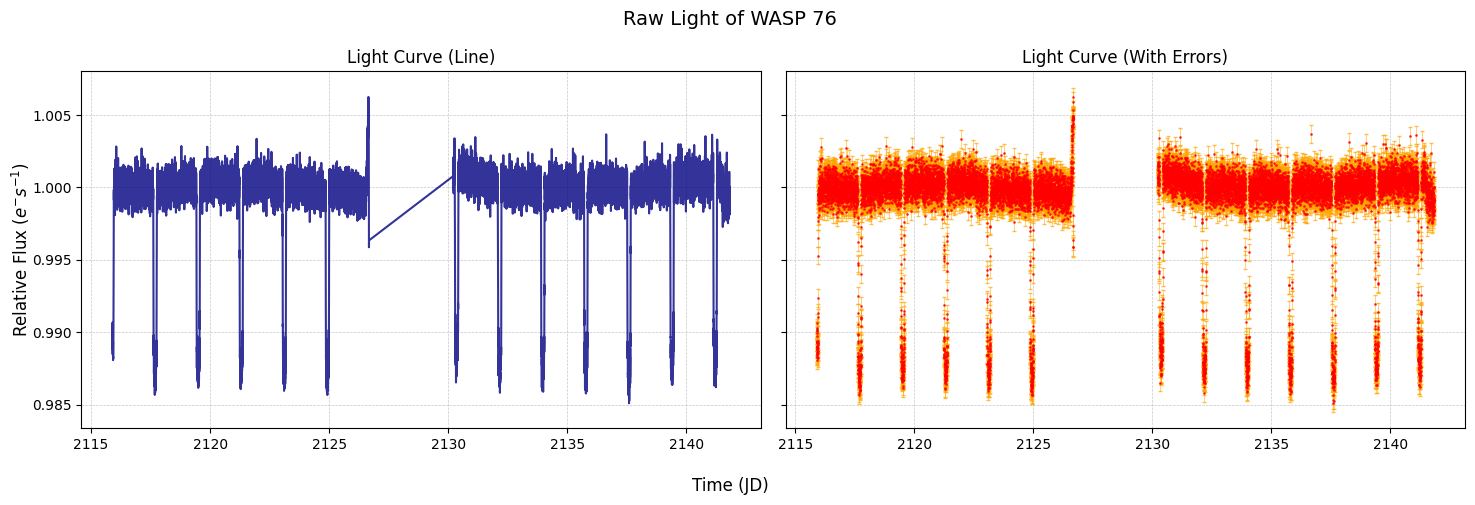

In [4]:
row = 0

lc = search_result[row].download().normalize().remove_nans()
time     = lc.time.value
flux     = lc.flux.value
flux_err = lc.flux_err.value

print(np.sqrt(1 - np.min(flux)) - np.sqrt(np.mean(flux_err)))
print(np.sqrt(np.max(flux) - np.min(flux)) - np.sqrt(np.mean(flux_err)))

lc_plot = lightcurve(time, flux, flux_err, target_name, 'Raw')
lc_plot.tight_layout()
lc_plot.show()

## Periodogram

C:\Users\simon\AppData\Local\Temp\ipykernel_3052\2100132109.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  pg_plot.show()


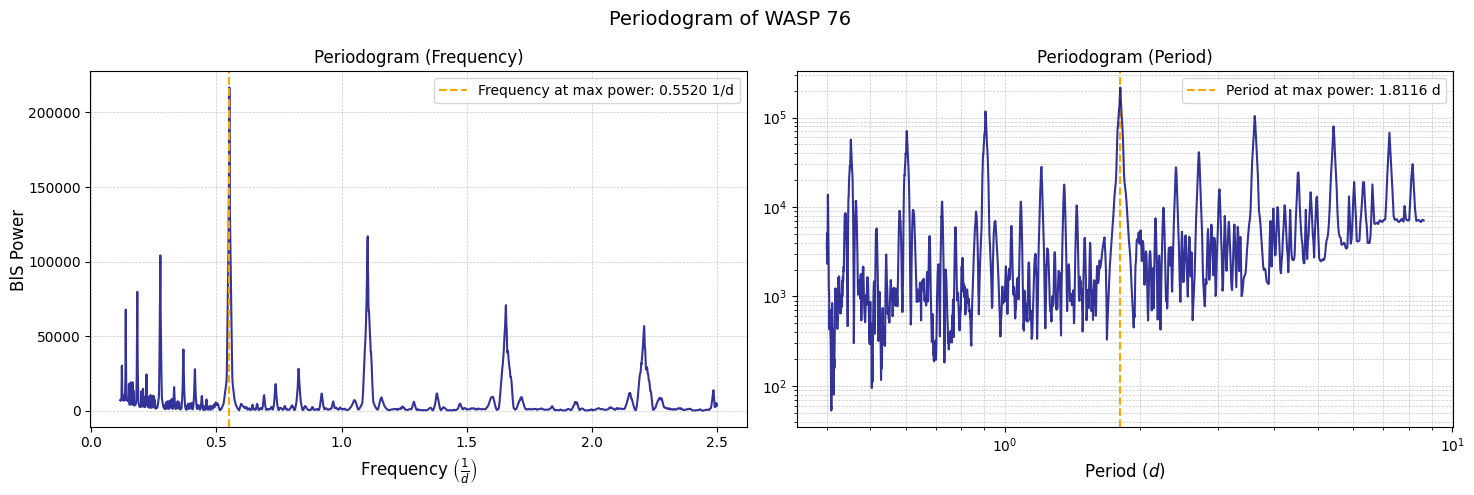

In [5]:
pg = lc.to_periodogram(method='bls', minimum_period=0.4)

freq  = pg.frequency.value
per   = pg.period.value 
power = pg.power.value
max_freq = pg.frequency_at_max_power.value
max_per  = pg.period_at_max_power.value

pg_plot = periodogram(freq, per, power, max_freq, max_per, target_name)
pg_plot.tight_layout()
pg_plot.show()

## Folded Light Curve

C:\Users\simon\AppData\Local\Temp\ipykernel_3052\2260128107.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fold_plot.show()


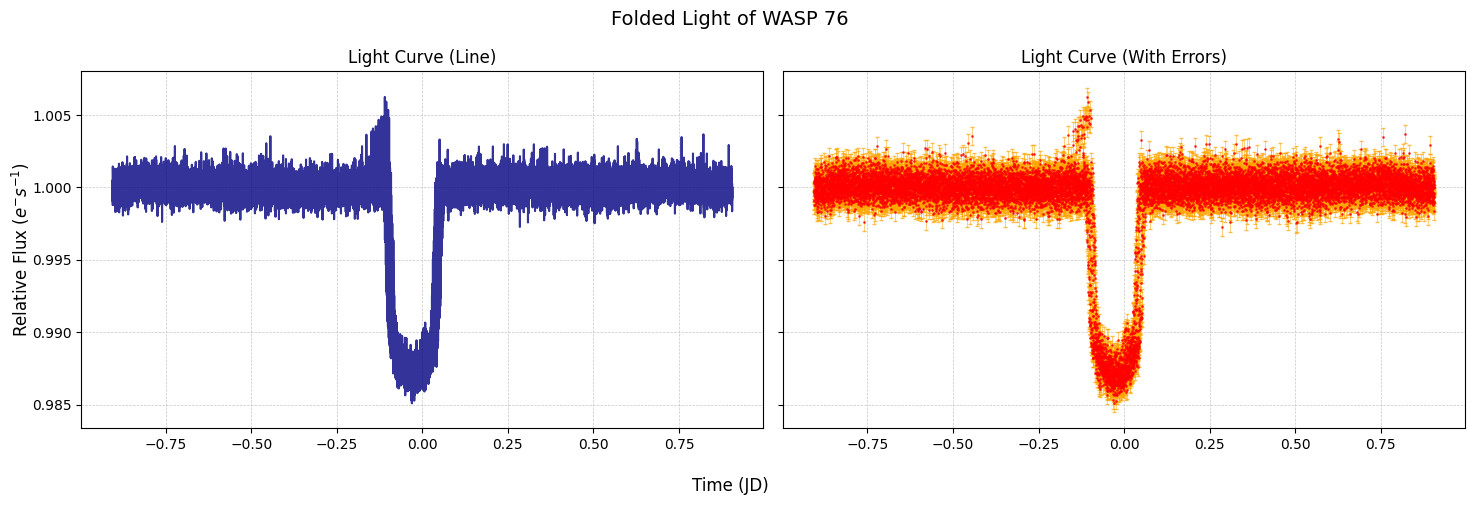

In [6]:
fold = lc.fold(period=max_per, epoch_time=lc.time[0].value)
            #    , epoch_phase=theta_max[0])

time_fold     = fold.time.value
flux_fold     = fold.flux.value
flux_fold_err = fold.flux_err.value


fold_plot = lightcurve(time_fold, flux_fold, flux_fold_err, target_name, 'Folded')
fold_plot.tight_layout()
fold_plot.show()

# Define and Generate the model

We then need to define the model we are gonna use to run the MCMC simulation. The goal is to define a vector of paramters $\theta$ which will be varying during the simulation.

We use the library `batman`, and we fix the calculation to a *quadratic* darkening model, calculated as such :

$$
I(\mu) = I_0 [1 - c_1(1 - \mu_1) - c_2(1 - \mu)^2], \quad \text{where } \mu = \sqrt{1 - x^2}, 0 \geq x \geq 1 
$$

# Run MCMC

## Setup and initials

In [ ]:
# ----- BOUNDS ------
BOUNDS = compute_bounds(flux, flux_err, max_per)
print(BOUNDS)

# ----- WALKERS -----
nwalkers = 46

# ------ STEPS ------
setps = 5000

# ------ INITAL -----
x0 = np.array([0, max_per, np.sqrt(1 - np.min(flux)) - np.sqrt(np.mean(flux_err)), 2.8*max_per**(2/3), 89.0, 0.5, 0.5])
res = minimize(neg_log_posterior, x0, args=(time, flux, flux_err, BOUNDS), method='L-BFGS-B')
if res.success:
    theta_map = res.x
    print("MAP estimate of parameters:", theta_map)
else:
    raise RuntimeError(f"Optimization failed: {res.message}")

# ---- EVOLUTION ----
ndim = len(theta_map)
p0 = [np.array(theta_map) + 1e-7 * np.random.randn(ndim) for i in range(nwalkers)]

# ------- DATA ------
data = (time, flux, flux_err)
data_fold = (time_fold, flux_fold, flux_fold_err)

[(-0.3, 0.3), (np.float64(3.36577196), np.float64(3.37577196)), (np.float64(0.24719710168576373), np.float64(0.5241679461846658)), (np.float64(17.116271064099376), np.float64(32.08788781112031)), (np.float64(87.58), np.float64(91.58)), (0, 1), (0, 1)]


c:\Users\simon\OneDrive\Bureau\Exoplot_final\exoplot_venv\Lib\site-packages\scipy\optimize\_optimize.py:2540: RuntimeWarning: invalid value encountered in scalar multiply
  tmp2 = (x - v) * (fx - fw)
c:\Users\simon\OneDrive\Bureau\Exoplot_final\exoplot_venv\Lib\site-packages\scipy\optimize\_optimize.py:2541: RuntimeWarning: invalid value encountered in scalar subtract
  p = (x - v) * tmp2 - (x - w) * tmp1


MAP estimate of parameters: [-0.14821726  3.37392524  0.24719712 32.0878877  91.58        0.99999997
  0.99999997]


In [ ]:
def diagnostic_posterior(theta_map, time, flux, flux_err, BOUNDS, 
                         log_posterior, log_likelihood, log_prior,
                         param_names=None, n_points=50, rel_range=0.1):
    """
    Plot 1D slices of the posterior, likelihood, and prior around theta_map.
    """
    ndim = len(theta_map)
    if param_names is None:
        param_names = [f"param_{i}" for i in range(ndim)]
    
    fig, axes = plt.subplots(ndim, 1, figsize=(6, 2.5*ndim), constrained_layout=True)

    for i in range(ndim):
        # Create a grid around theta_map[i]
        theta0 = theta_map.copy()
        low, high = BOUNDS[i]
        center = theta_map[i]
        width = rel_range * (high - low)

        # Avoid exceeding bounds
        grid = np.linspace(
            max(low, center - width),
            min(high, center + width),
            n_points
        )
        lps, lls, prs = [], [], []
        
        for val in grid:
            theta = theta0.copy()
            theta[i] = val
            lp = log_prior(theta, BOUNDS)
            ll = log_likelihood(theta, time, flux, flux_err)
            post = lp + ll
            lps.append(post)
            lls.append(ll)
            prs.append(lp)

        ax = axes[i]
        ax.plot(grid, lps, label='log posterior')
        ax.plot(grid, lls, label='log likelihood', linestyle='--')
        ax.plot(grid, prs, label='log prior', linestyle=':')
        ax.axvline(center, color='k', linestyle='-', alpha=0.5)
        ax.set_xlabel(param_names[i])
        ax.set_ylabel('log prob')
        ax.legend()
        ax.grid(True)

    plt.show()

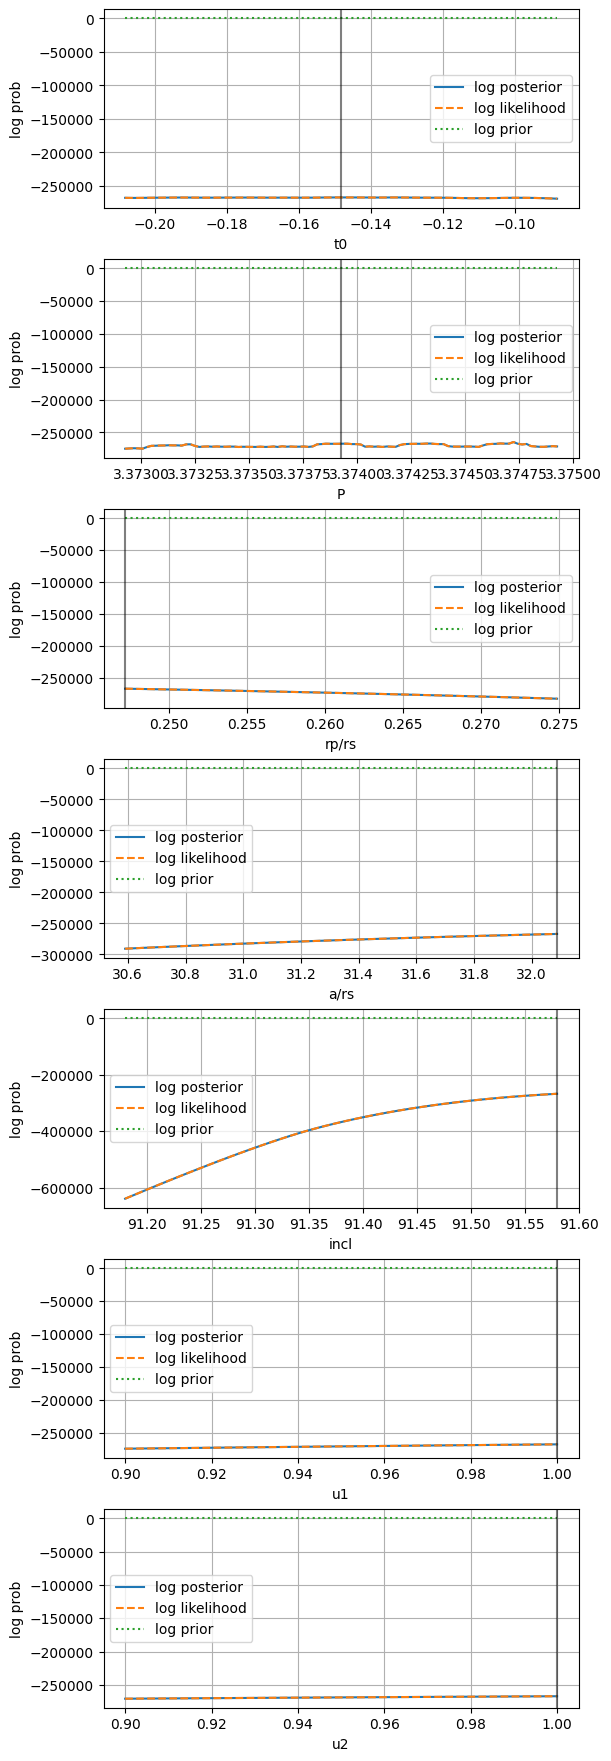

In [9]:
param_names = ["t0", "P", "rp/rs", "a/rs", "incl", "u1", "u2"]

diagnostic_posterior(
    theta_map,
    time, flux, flux_err,
    BOUNDS,
    log_posterior,
    log_likelihood,
    log_prior,
    param_names=param_names,
    n_points=100,  # more points for smoother curves
    rel_range=0.1  # explore ±10% of each param range
)

### Run MCMC Simulation

We use the library `emcee` to execute the simulation.

In [10]:
sampler, pos, prob, state = mcmc(p0, nwalkers, setps, ndim, log_likelihood, data)

Running burn-in...


Burn-in: 100%|██████████| 500/500 [00:41<00:00, 12.02it/s]


Mean acceptance fraction (burn-in): 0.213 (recommended ~0.2–0.5)
Running production...


Production:   0%|          | 0/5000 [00:00<?, ?it/s]


ValueError: Initial state has a large condition number. Make sure that your walkers are linearly independent for the best performance

In [ ]:
chain = sampler.get_chain()
log_prob = sampler.get_log_prob()

np.save("samples.npy", chain)
np.save("log_prob.npy", log_prob)

# chain = np.load("samples.npy")
# log_prob = np.load("log_prob.npy")

samples = chain.reshape(-1, chain.shape[-1])
flat_log_prob = log_prob.reshape(-1)

theta_max = samples[np.argmax(flat_log_prob)]

In [ ]:
for i in range(samples.shape[1]):
    mcmc = np.percentile(samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    print(f"{LABELS[i]}: {mcmc[1]:.5f} (+{q[1]:.5f}/-{q[0]:.5f})")

$t_0 \, \left( JD \right)$: -0.09091 (+0.19677/-0.18420)
$P \, \left( JD \right)$: 3.37081 (+0.00019/-0.00020)
$R_p \left( \frac{R_p}{R_s} \right)$: 0.40170 (+0.04414/-0.02307)
$a \left( R_s \right)$: 23.72239 (+3.60213/-1.84922)
$I \left( \text{degree} \right)$: 88.68552 (+1.99567/-0.45997)
u1: 0.37929 (+54868589681.69183/-508571033222.16486)
u2: -1.79415 (+557603239322.56775/-59886723771.22088)


### Plotting and Visualize Results

We now present a few different plots to visualize our simulation.

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\718021134.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  model_tryouts.show()


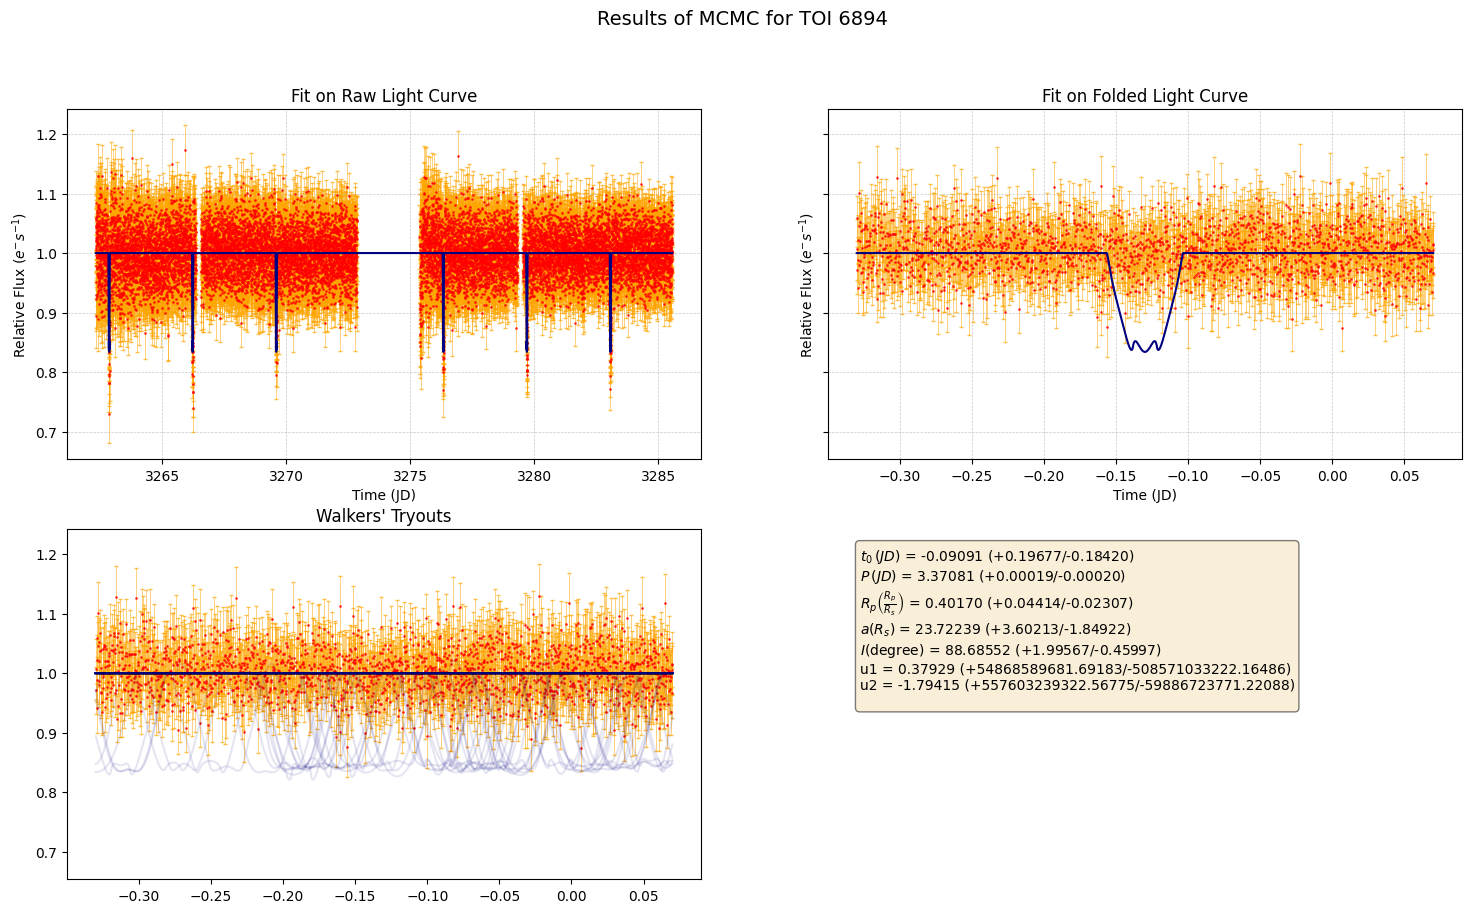

In [ ]:
epoch_phase = (lc.time[0].value + (theta_max[0] * max_per)) % max_per

fold = lc.fold(period=max_per, epoch_phase=-0.10)

time_fold     = fold.time.value
flux_fold     = fold.flux.value
flux_fold_err = fold.flux_err.value

model_tryouts = model(time, flux, flux_err, time_fold, flux_fold, flux_fold_err, target_name, samples, flat_log_prob)
model_tryouts.tight_layout
model_tryouts.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\1859204565.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  evolution_plot.show()


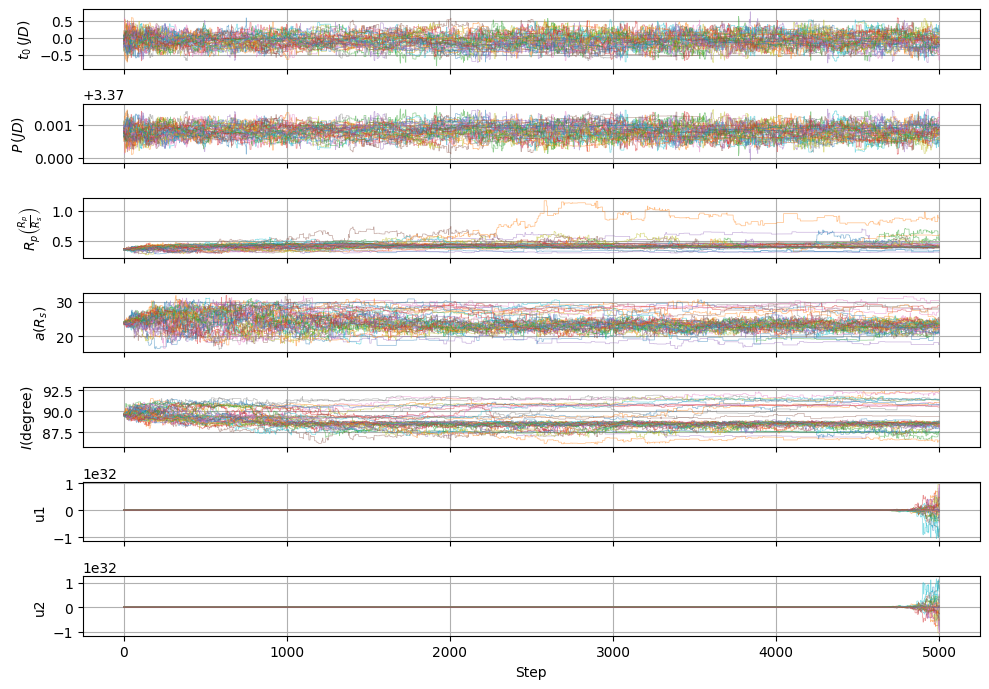

In [ ]:
evolution_plot = evolution(chain)
evolution_plot.tight_layout()
evolution_plot.show()

C:\Users\simon\AppData\Local\Temp\ipykernel_16500\2186451352.py:3: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  corner_plot.show()


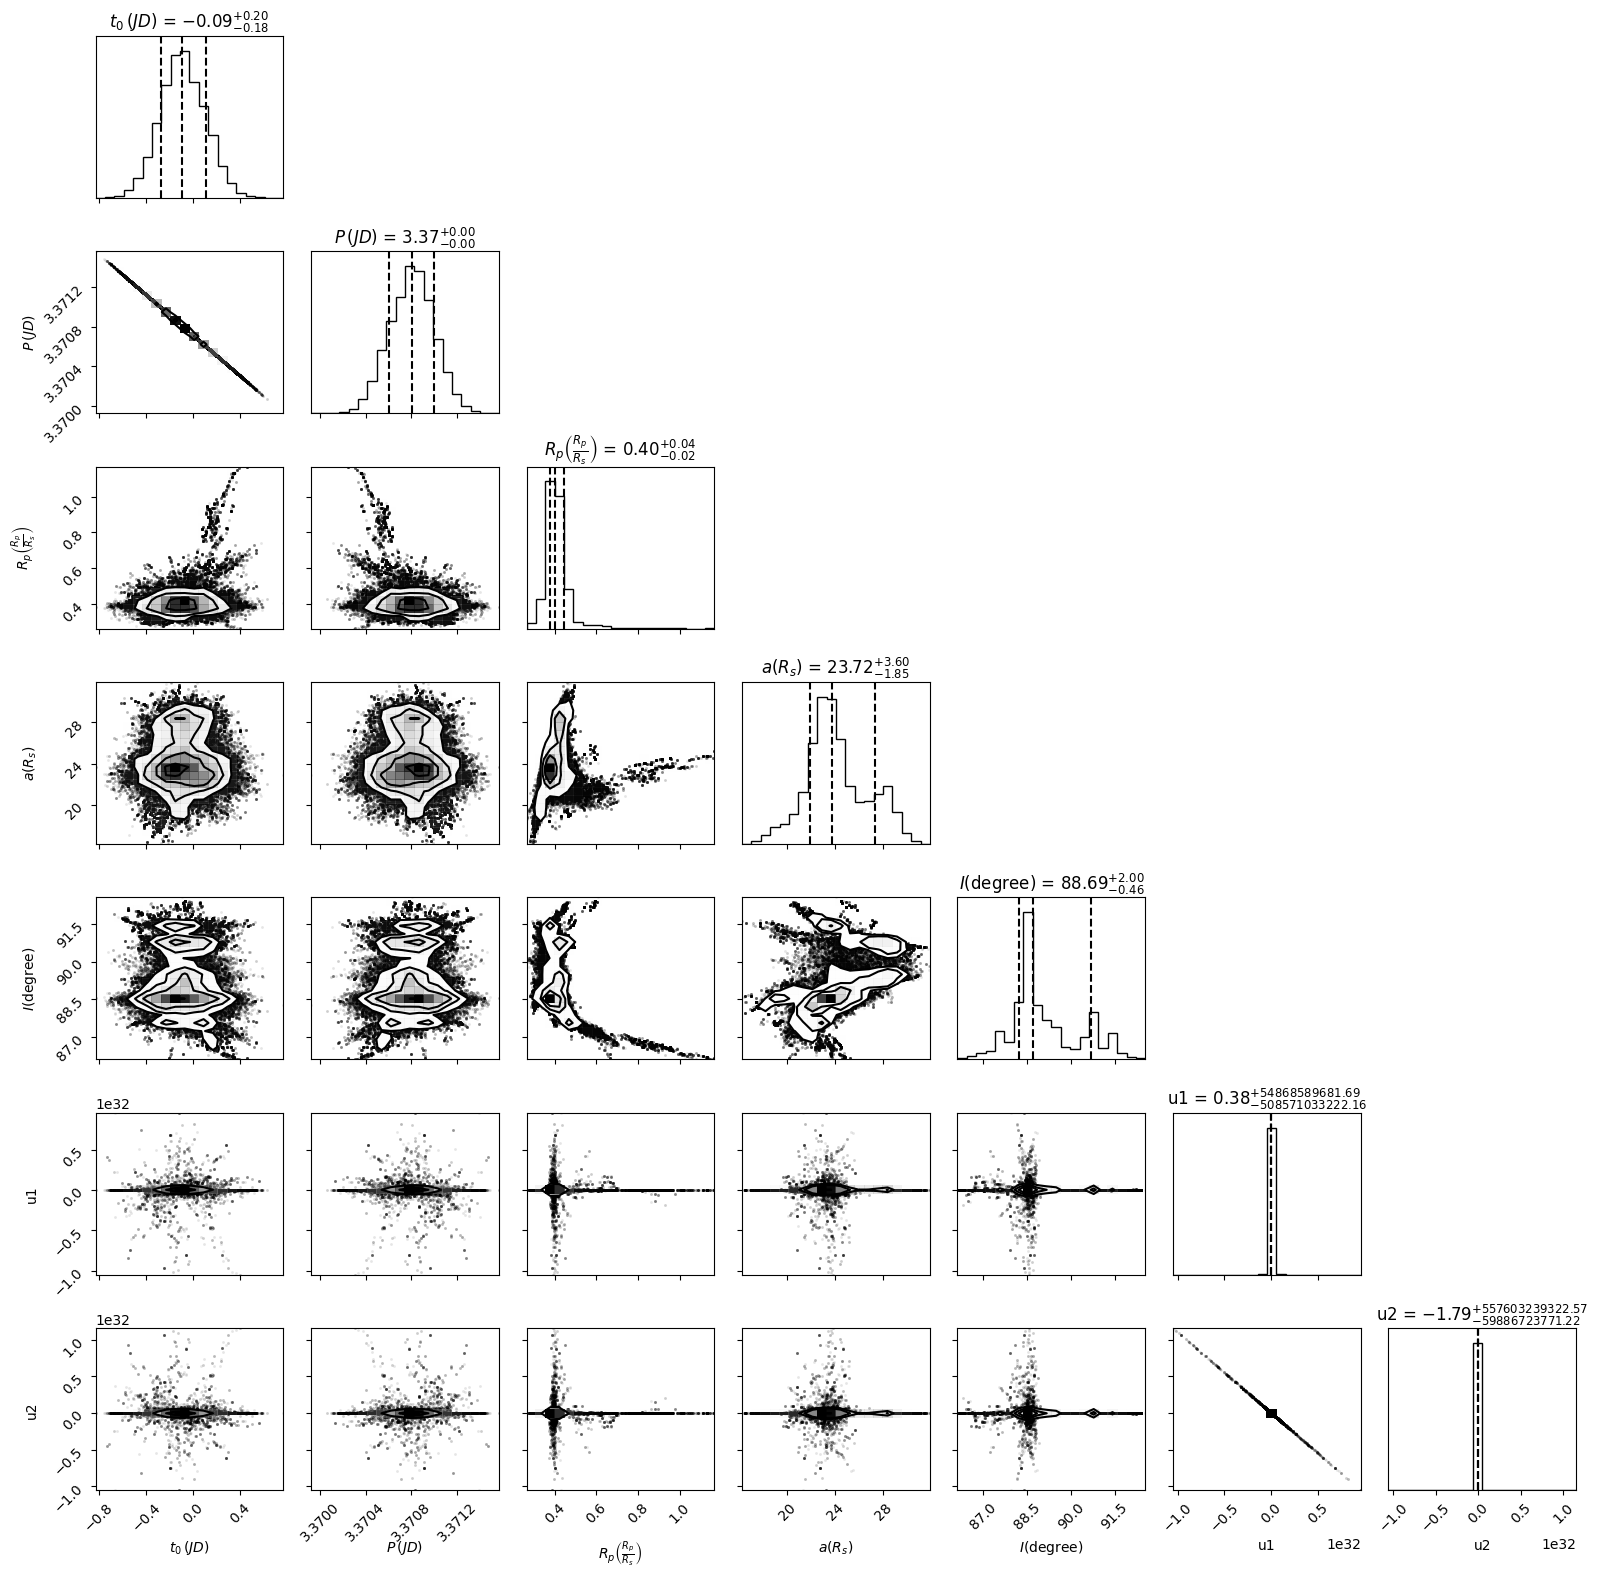

In [ ]:
corner_plot = corner_plot(samples)
corner_plot.tight_layout()
corner_plot.show()